# Acquiring Data


In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

 90% 134M/149M [00:00<00:00, 186MB/s]
100% 149M/149M [00:00<00:00, 176MB/s]


In [3]:
!unzip /content/brain-tumor-mri-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training

# Import

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.layers import Input
from keras import layers
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image Preprocessing

In [5]:
# declare train data and val data directory
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [6]:
def resize_and_pad_image(image):
    # Convert numpy array to TensorFlow tensor
    image = tf.convert_to_tensor(image)

    # If image is grayscale (channel size is 1), convert to RGB
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    # Resize and pad the image
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)

    return image

In [7]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    fill_mode = 'nearest',
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    #preprocessing_function=resize_and_pad_image,
)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    #preprocessing_function=resize_and_pad_image
)

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # data train directory
        target_size=(224, 224),  # image res 256x256 px
        batch_size=32,
        class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
        test_dir, # val data directory
        target_size=(224, 224), # image res 256x256 px
        batch_size=40,
        class_mode='categorical',
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Show Images Example

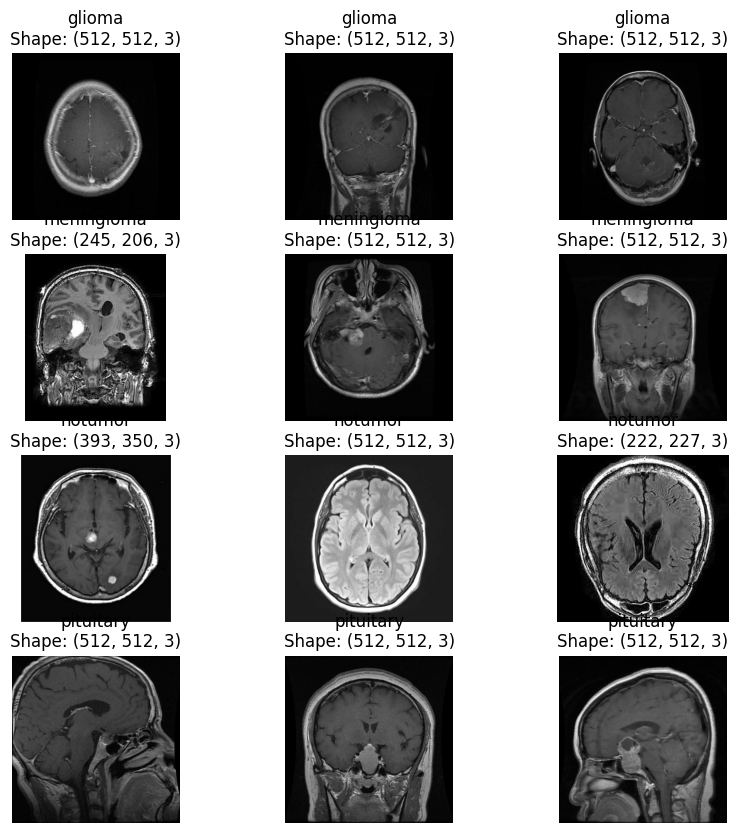

In [9]:
classes = os.listdir(train_dir)

n = 3

fig, axs = plt.subplots(len(classes), n, figsize=(10, 10))

for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    img_class = os.listdir(class_path)

    for i in range(n):
        img_path = os.path.join(class_path, img_class[i])

        image = cv2.imread(img_path)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        shape = image.shape

        axs[idx, i].imshow(image_rgb)
        axs[idx, i].axis('off')
        axs[idx, i].set_title(f'{class_name}\nShape: {shape}')

plt.show()

# Transfer Learning with Densenet121

In [10]:
pre_trained_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

29084464/29084464 [==============================] - 0s 0us/step


# Fine Tuning

In [11]:
"""freeze_index = None
for i,layer in enumerate(pre_trained_model.layers):
    if 'conv4' in layer._name:
        freeze_index = i
        break"""

for layer in pre_trained_model.layers[:10]:
    layer.trainable = False

In [12]:
x = pre_trained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [13]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
checkpointer = ModelCheckpoint(filepath='model/best_model_densenet121.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=0.000001
)

In [15]:
history = model.fit(train_generator, epochs=15,
                    validation_data = test_generator,
                    batch_size=256,
                    callbacks=[checkpointer, reduce_lr])

Epoch 1/15
179/179 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8748
Epoch 1: val_loss improved from inf to 0.21531, saving model to model/best_model_densenet121.h5
179/179 [==============================] - 190s 598ms/step - loss: 0.3405 - accuracy: 0.8748 - val_loss: 0.2153 - val_accuracy: 0.9275 - lr: 1.0000e-04
Epoch 2/15
179/179 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9639
Epoch 2: val_loss did not improve from 0.21531
179/179 [==============================] - 93s 517ms/step - loss: 0.1040 - accuracy: 0.9639 - val_loss: 0.2275 - val_accuracy: 0.9230 - lr: 1.0000e-04
Epoch 3/15
179/179 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9774
Epoch 3: val_loss improved from 0.21531 to 0.15986, saving model to model/best_model_densenet121.h5
179/179 [==============================] - 94s 522ms/step - loss: 0.0626 - accuracy: 0.9774 - val_loss: 0.1599 - val_accuracy: 0.9542 - lr: 1.0000e-04
Epoch 4/15
179/

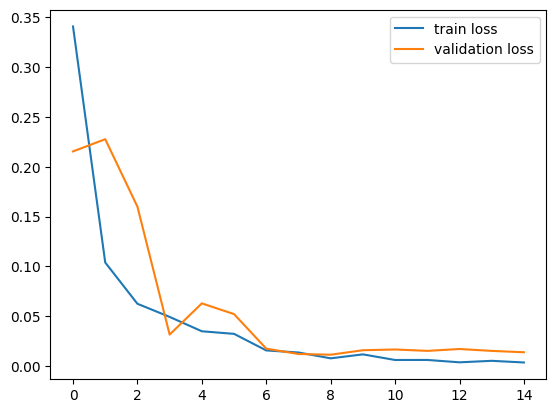

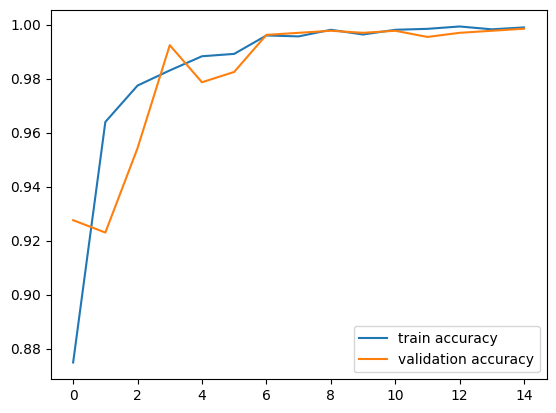

In [17]:
# plot report from model
def report_train(history):
    # loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.show()
    # accuracy
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.show()

report_train(history)